In [1]:
%matplotlib inline

## Datasets Preparation

- Create Balanced Data set from the good quality images of the 1.25x 
- This dataset will have 200 images for each class.
- the remain images will be moved to the Val and Test datasets.
- The split between the val - test will be 50%-50%.
- I want to measure the performance of balanced dataset compared to the original which received good score

In [23]:
# import YOLO model
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os

## Comparison between Different Yolo Models
Currently only YOLO v8 and v11 support image classification
- YOLO v8
- YOLO v11


In [24]:
yolo_classification_checkpoints = {
    "YOLOv8": {
        "Nano": "yolov8n-cls.pt",
        "Small": "yolov8s-cls.pt",
        "Medium": "yolov8m-cls.pt",
        "Large": "yolov8l-cls.pt",
        "XLarge": "yolov8x-cls.pt",
    },
        "YOLOv11": {
        "Nano": "yolo11n-cls.pt",
        "Small": "yolo11s-cls.pt",
        "Medium": "yolo11m-cls.pt",
        "Large": "yolo11l-cls.pt",
        "XLarge": "yolo11x-cls.pt",
    },
}

Functions to fine tune each model and then evaluate it

In [25]:
def train_model(data_path, model_name, model_size, epochs=10, imgsz=128):
    # Load the model checkpoint
    checkpoint = yolo_classification_checkpoints[model_name][model_size]
    model = YOLO(checkpoint)
    
    # Train the model
    model.train(data=data_path, epochs=epochs, imgsz=imgsz)
    
    return model

def eval_model(model, test_data_path):
    # Get class names from the test dataset directory
    class_names = sorted(os.listdir(test_data_path))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    # Initialize lists for true labels (y_test) and predicted labels (y_pred)
    y_test = []
    y_pred = []

    # Initialize a list to store image data for plotting
    images_for_plotting = []

    # Process each class in the test directory
    for class_name in class_names:
        class_dir = os.path.join(test_data_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            
            # Load the image and run the model prediction
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
            results = model(img)
            
            # Get the predicted class index
            predicted_idx = int(results[0].probs.data.argmax())
            
            # Append true and predicted labels
            y_test.append(class_to_idx[class_name])
            y_pred.append(predicted_idx)
            
            # Store the image, true label, and predicted label for plotting
            images_for_plotting.append((img_rgb, class_name, class_names[predicted_idx]))

    # Evaluate using classification metrics
    classification_report_result = classification_report(y_test, y_pred, target_names=class_names)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_matrix_result = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return classification_report_result, accuracy, confusion_matrix_result, precision, recall, f1, images_for_plotting
    
def plot_results(images_for_plotting):
    # Plot images with true and predicted labels
    plt.figure(figsize=(12, 12))
    num_images = len(images_for_plotting)  # Display all images (adjust as needed)
    rows = (num_images // 4) + 1  # Adjust rows based on the number of images

    for i in range(num_images):
        img, true_label, pred_label = images_for_plotting[i]
        plt.subplot(rows, 4, i + 1)  # Dynamic row setting
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color="green" if true_label == pred_label else "red")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [26]:
import os

# iterate over each dataset in the datasets folder
balanced_datasets = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets"
data_paths = [os.path.join(balanced_datasets, dataset) for dataset in os.listdir(balanced_datasets)]

results = []  # List to store the evaluation results

for data_path in data_paths:
    test_data_path = os.path.join(data_path, "test")
    # run the functions for each of the models
    for model_name in yolo_classification_checkpoints:
        for model_size in yolo_classification_checkpoints[model_name]:
            print(f"Training {model_name} {model_size} model...")
            model = train_model(data_path, model_name, model_size, epochs=10, imgsz=128)
            
            print(f"Evaluating {model_name} {model_size} model...")
            classification_report_result, accuracy, confusion_matrix_result, precision, recall, f1, images_for_plotting = eval_model(model, test_data_path)
            
    
            # Append the evaluation results to the list
            results.append({
                "Model_Name": model_name,
                "Model_Size": model_size,
                "Classification Report": classification_report_result,
                "Accuracy": accuracy,
                "Average Precision": precision,
                "Average Recall": recall,
                "Average f1": f1,
                "Confusion Matrix": confusion_matrix_result,
                "Images for Plotting": images_for_plotting
            })

Training YOLOv8 Nano model...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1, epochs=10, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train74, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train74
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.42it/s]

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 102.25it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.62it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.19it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 93.07it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 95.79it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 112.37it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.53it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.74it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.463G     0.3149          6        128: 100%|██████████| 54/54 [00:01<00:00, 34.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.02it/s]

                   all      0.947          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train74/weights/last.pt, 3.0MB
Optimizer stripped from /home/etaylor/runs/classify/train74/weights/best.pt, 3.0MB

Validating /home/etaylor/runs/classify/train74/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/etaylor/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.26it/s]


                   all      0.955          1
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train74
Evaluating YOLOv8 Nano model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.4ms preprocess, 4.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.2ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.2ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train75
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 102.15it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 108.99it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 104.19it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.89it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 93.86it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 106.51it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 100.68it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.39it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.85it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.522G     0.2933          6        128: 100%|██████████| 54/54 [00:01<00:00, 37.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 102.21it/s]

                   all      0.962          1



10 epochs completed in 0.006 hours.
Optimizer stripped from /home/etaylor/runs/classify/train75/weights/last.pt, 10.3MB
Optimizer stripped from /home/etaylor/runs/classify/train75/weights/best.pt, 10.3MB

Validating /home/etaylor/runs/classify/train75/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/etayl

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.03it/s]


                   all       0.97          1
Speed: 0.6ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train75
Evaluating YOLOv8 Small model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 3.9ms
Speed: 1.5ms preprocess, 3.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.4ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 4.1ms
Speed: 1.4ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train76
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.53it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.44it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.23it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.79it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.14it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.90it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.89it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.31it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.47it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.902G      0.251          6        128: 100%|██████████| 54/54 [00:02<00:00, 26.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.67it/s]

                   all      0.947          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train76/weights/last.pt, 31.7MB
Optimizer stripped from /home/etaylor/runs/classify/train76/weights/best.pt, 31.7MB

Validating /home/etaylor/runs/classify/train76/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,766,499 parameters, 0 gradients, 41.6 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 15.49it/s]


                   all      0.962          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train76
Evaluating YOLOv8 Medium model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.9ms
Speed: 1.4ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train77
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.03it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.37it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.24it/s]


                   all      0.955          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.99it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.30it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.32it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.24it/s]


                   all      0.955          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.44it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.22it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.72G      0.208          6        128: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.15it/s]


                   all      0.955          1

10 epochs completed in 0.035 hours.
Optimizer stripped from /home/etaylor/runs/classify/train77/weights/last.pt, 72.6MB
Optimizer stripped from /home/etaylor/runs/classify/train77/weights/best.pt, 72.6MB

Validating /home/etaylor/runs/classify/train77/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8l-cls summary (fused): 133 layers, 36,188,419 parameters, 0 gradients, 98.7 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 26

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.58it/s]


                   all       0.97          1
Speed: 0.0ms preprocess, 2.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train77
Evaluating YOLOv8 Large model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train78
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.32it/s]

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.30it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.37it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.89it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.17it/s]


                   all      0.924          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.24it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.19it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.79it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.19it/s]


                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.82G     0.1958          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.08it/s]

                   all      0.932          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train78/weights/last.pt, 112.5MB
Optimizer stripped from /home/etaylor/runs/classify/train78/weights/best.pt, 112.5MB

Validating /home/etaylor/runs/classify/train78/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8x-cls summary (fused): 133 layers, 56,127,043 parameters, 0 gradients, 153.8 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 11.41it/s]


                   all      0.958          1
Speed: 0.0ms preprocess, 2.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train78
Evaluating YOLOv8 XLarge model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.0ms
Speed: 1.2ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.2ms
Speed: 1.4ms preprocess, 8.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train79
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.30it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.38it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 81.42it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.69it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.68it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.33it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.62it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.23it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.76it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.05G     0.3138          6        128: 100%|██████████| 54/54 [00:01<00:00, 27.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.20it/s]

                   all      0.962          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train79/weights/last.pt, 3.2MB
Optimizer stripped from /home/etaylor/runs/classify/train79/weights/best.pt, 3.2MB

Validating /home/etaylor/runs/classify/train79/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/etaylor

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.74it/s]


                   all       0.97          1
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train79
Evaluating YOLOv11 Nano model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.0ms
Speed: 1.4ms preprocess, 6.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train80
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.81it/s]

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.43it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.41it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.28it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.93it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.32it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.34it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.07it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.14it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.812G     0.2876          6        128: 100%|██████████| 54/54 [00:01<00:00, 27.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.38it/s]


                   all      0.958          1

10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train80/weights/last.pt, 11.0MB
Optimizer stripped from /home/etaylor/runs/classify/train80/weights/best.pt, 11.0MB

Validating /home/etaylor/runs/classify/train80/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-cls summary (fused): 112 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.64it/s]


                   all      0.958          1
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train80
Evaluating YOLOv11 Small model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.1ms
Speed: 1.4ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train81
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.59it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.59it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.01it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 64.19it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 64.16it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.93it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.69it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.79it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 66.52it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.801G     0.2454          6        128: 100%|██████████| 54/54 [00:02<00:00, 20.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.43it/s]

                   all      0.958          1



10 epochs completed in 0.032 hours.
Optimizer stripped from /home/etaylor/runs/classify/train81/weights/last.pt, 20.9MB
Optimizer stripped from /home/etaylor/runs/classify/train81/weights/best.pt, 20.9MB

Validating /home/etaylor/runs/classify/train81/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11m-cls summary (fused): 138 layers, 10,345,475 parameters, 0 gradients, 39.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 15.72it/s]


                   all      0.962          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train81
Evaluating YOLOv11 Medium model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train82
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.59it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 41.82it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.95it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 34.49it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.84it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.85it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.09it/s]


                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.31it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 42.35it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.04G     0.2726          6        128: 100%|██████████| 54/54 [00:03<00:00, 13.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.30it/s]

                   all      0.951          1



10 epochs completed in 0.036 hours.
Optimizer stripped from /home/etaylor/runs/classify/train82/weights/last.pt, 25.9MB
Optimizer stripped from /home/etaylor/runs/classify/train82/weights/best.pt, 25.9MB

Validating /home/etaylor/runs/classify/train82/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11l-cls summary (fused): 227 layers, 12,822,275 parameters, 0 gradients, 49.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 13.97it/s]


                   all      0.973          1
Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train82
Evaluating YOLOv11 Large model...

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.6ms
Speed: 1.4ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train83
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.46it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.84it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.00it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.61it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.61it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.77it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.47it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.40it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.22it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.59G     0.2678          6        128: 100%|██████████| 54/54 [00:04<00:00, 11.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.27it/s]

                   all      0.966          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train83/weights/last.pt, 57.0MB
Optimizer stripped from /home/etaylor/runs/classify/train83/weights/best.pt, 57.0MB

Validating /home/etaylor/runs/classify/train83/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11x-cls summary (fused): 227 layers, 28,336,259 parameters, 0 gradients, 110.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/val... found 264 images in 3 classes ✅ 
test: /sise/home/et

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


                   all      0.966          1
Speed: 0.0ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train83
Evaluating YOLOv11 XLarge model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train84
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.90it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 81.43it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 78.93it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.01it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.46it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.15it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 95.96it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.12it/s]


                   all      0.955          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.62it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.21G     0.3106          6        128: 100%|██████████| 54/54 [00:01<00:00, 37.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.21it/s]

                   all      0.958          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train84/weights/last.pt, 3.0MB
Optimizer stripped from /home/etaylor/runs/classify/train84/weights/best.pt, 3.0MB

Validating /home/etaylor/runs/classify/train84/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/etaylor/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.11it/s]


                   all      0.958          1
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train84
Evaluating YOLOv8 Nano model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.4ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.4ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 4.5ms
Speed: 1.3ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.4ms
Speed: 1.3ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.6ms
Speed: 1.4ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 cloudy 0.44, clear 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train85
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.49it/s]

                   all      0.848          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.68it/s]

                   all      0.799          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 87.70it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 95.40it/s]


                   all      0.913          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.80it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.78it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.12it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.39it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.44it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.705G     0.2491          6        128: 100%|██████████| 54/54 [00:01<00:00, 38.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.45it/s]

                   all      0.939          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train85/weights/last.pt, 10.3MB
Optimizer stripped from /home/etaylor/runs/classify/train85/weights/best.pt, 10.3MB

Validating /home/etaylor/runs/classify/train85/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/etayl

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.65it/s]


                   all      0.955          1
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train85
Evaluating YOLOv8 Small model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.87, cloudy 0.12, clear 0.00, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.4ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 cloudy 0.71, amber 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train86
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.79it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.66it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.05it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.61it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.87it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.34it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.71it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.87it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.57it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.925G     0.2331          6        128: 100%|██████████| 54/54 [00:02<00:00, 26.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.72it/s]

                   all      0.947          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train86/weights/last.pt, 31.7MB
Optimizer stripped from /home/etaylor/runs/classify/train86/weights/best.pt, 31.7MB

Validating /home/etaylor/runs/classify/train86/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,766,499 parameters, 0 gradients, 41.6 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


                   all      0.958          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train86
Evaluating YOLOv8 Medium model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.62, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train87
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.29it/s]

                   all      0.833          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.15it/s]


                   all      0.917          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.30it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.01it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.83it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.28it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.58it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.55it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.71G     0.1716          6        128: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.66it/s]

                   all      0.943          1



10 epochs completed in 0.035 hours.
Optimizer stripped from /home/etaylor/runs/classify/train87/weights/last.pt, 72.6MB
Optimizer stripped from /home/etaylor/runs/classify/train87/weights/best.pt, 72.6MB

Validating /home/etaylor/runs/classify/train87/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8l-cls summary (fused): 133 layers, 36,188,419 parameters, 0 gradients, 98.7 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 13.93it/s]


                   all      0.962          1
Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train87
Evaluating YOLOv8 Large model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.96, cloudy 0.04, clear 0.00, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 cloudy 0.78, amber 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train88
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.87it/s]

                   all      0.818          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.23it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.43it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.34it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.07it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.29it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.94it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.16it/s]


                   all      0.943          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.40it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.81G     0.1796          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.70it/s]

                   all      0.939          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train88/weights/last.pt, 112.5MB
Optimizer stripped from /home/etaylor/runs/classify/train88/weights/best.pt, 112.5MB

Validating /home/etaylor/runs/classify/train88/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8x-cls summary (fused): 133 layers, 56,127,043 parameters, 0 gradients, 153.8 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


                   all      0.973          1
Speed: 0.0ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train88
Evaluating YOLOv8 XLarge model...

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 cloudy 0.50, amber 0.38, clear 0.12, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.86, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train89
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.71it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 67.39it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.69it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.43it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.04it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.50it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 67.15it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.20it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.50it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         2G     0.2903          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 77.99it/s]

                   all      0.932          1



10 epochs completed in 0.029 hours.
Optimizer stripped from /home/etaylor/runs/classify/train89/weights/last.pt, 3.2MB
Optimizer stripped from /home/etaylor/runs/classify/train89/weights/best.pt, 3.2MB

Validating /home/etaylor/runs/classify/train89/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/etaylor

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train89
Evaluating YOLOv11 Nano model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.57, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train90
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.87it/s]

                   all      0.879          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.08it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 78.72it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.07it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.47it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.77it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.98it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.11it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.68it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.814G     0.2459          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.93it/s]

                   all      0.943          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train90/weights/last.pt, 11.0MB
Optimizer stripped from /home/etaylor/runs/classify/train90/weights/best.pt, 11.0MB

Validating /home/etaylor/runs/classify/train90/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-cls summary (fused): 112 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/etay

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.14it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train90
Evaluating YOLOv11 Small model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.95, cloudy 0.05, clear 0.00, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.76, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train91
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 59.61it/s]


                   all      0.864          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 61.36it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.20it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.62it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 57.05it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.70it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.14it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.09it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 64.27it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.797G     0.2312          6        128: 100%|██████████| 54/54 [00:02<00:00, 21.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.17it/s]

                   all      0.947          1



10 epochs completed in 0.032 hours.
Optimizer stripped from /home/etaylor/runs/classify/train91/weights/last.pt, 20.9MB
Optimizer stripped from /home/etaylor/runs/classify/train91/weights/best.pt, 20.9MB

Validating /home/etaylor/runs/classify/train91/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11m-cls summary (fused): 138 layers, 10,345,475 parameters, 0 gradients, 39.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.12it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train91
Evaluating YOLOv11 Medium model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.86, cloudy 0.14, clear 0.00, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.2ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.52, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train92
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.05it/s]

                   all      0.826          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 42.93it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.73it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 47.18it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 48.27it/s]


                   all      0.924          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.57it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 42.99it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.52it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.03G      0.246          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 47.35it/s]

                   all      0.943          1



10 epochs completed in 0.036 hours.
Optimizer stripped from /home/etaylor/runs/classify/train92/weights/last.pt, 25.9MB
Optimizer stripped from /home/etaylor/runs/classify/train92/weights/best.pt, 25.9MB

Validating /home/etaylor/runs/classify/train92/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11l-cls summary (fused): 227 layers, 12,822,275 parameters, 0 gradients, 49.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 14.57it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train92
Evaluating YOLOv11 Large model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.95, cloudy 0.05, clear 0.00, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.9

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train93
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.40it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.42it/s]

                   all      0.845          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.51it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.63it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.64it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.47it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.83it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.61it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 32.94it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.59G     0.2512          6        128: 100%|██████████| 54/54 [00:04<00:00, 11.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.45it/s]

                   all      0.939          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train93/weights/last.pt, 57.0MB
Optimizer stripped from /home/etaylor/runs/classify/train93/weights/best.pt, 57.0MB

Validating /home/etaylor/runs/classify/train93/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11x-cls summary (fused): 227 layers, 28,336,259 parameters, 0 gradients, 110.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_2/val... found 264 images in 3 classes ✅ 
test: /sise/home/et

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.79it/s]


                   all      0.955          1
Speed: 0.0ms preprocess, 2.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train93
Evaluating YOLOv11 XLarge model...

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 cloudy 0.54, amber 0.46, clear 0.00, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train94
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.01it/s]

                   all      0.826          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 98.62it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 95.30it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.35it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 93.30it/s]


                   all      0.898          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.66it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.41it/s]


                   all      0.932          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.99it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 118.87it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.26G      0.301          6        128: 100%|██████████| 54/54 [00:01<00:00, 38.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.51it/s]

                   all       0.92          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train94/weights/last.pt, 3.0MB
Optimizer stripped from /home/etaylor/runs/classify/train94/weights/best.pt, 3.0MB

Validating /home/etaylor/runs/classify/train94/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/etaylor/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


                   all      0.939          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train94
Evaluating YOLOv8 Nano model...

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.4ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.74, cloudy 0.21, clear 0.05, 4.7ms
Speed: 1.4ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.3ms
Speed: 1.4ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.96, cloudy 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train95
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.82it/s]

                   all      0.837          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.95it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.09it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 98.31it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 100.88it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 98.32it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.92it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.45it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 106.05it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.768G     0.2578          6        128: 100%|██████████| 54/54 [00:01<00:00, 37.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.03it/s]

                   all      0.947          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train95/weights/last.pt, 10.3MB
Optimizer stripped from /home/etaylor/runs/classify/train95/weights/best.pt, 10.3MB

Validating /home/etaylor/runs/classify/train95/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/etayl

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.76it/s]


                   all      0.958          1
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train95
Evaluating YOLOv8 Small model...

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 3.9ms
Speed: 1.4ms preprocess, 3.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.2ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train96
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.93it/s]

                   all      0.814          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.49it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.87it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.25it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.48it/s]

                   all      0.879          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.01it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.86it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.79it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.53it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.875G     0.2243          6        128: 100%|██████████| 54/54 [00:02<00:00, 26.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.70it/s]

                   all      0.917          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train96/weights/last.pt, 31.7MB
Optimizer stripped from /home/etaylor/runs/classify/train96/weights/best.pt, 31.7MB

Validating /home/etaylor/runs/classify/train96/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,766,499 parameters, 0 gradients, 41.6 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 15.76it/s]


                   all      0.943          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train96
Evaluating YOLOv8 Medium model...

0: 128x128 amber 0.80, cloudy 0.20, clear 0.00, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train97
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.49it/s]

                   all      0.833          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.58it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.14it/s]


                   all      0.924          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.19it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.07it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.10it/s]


                   all      0.943          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.82it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.83it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.97it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.73G     0.1712          6        128: 100%|██████████| 54/54 [00:02<00:00, 18.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.84it/s]

                   all      0.947          1



10 epochs completed in 0.035 hours.
Optimizer stripped from /home/etaylor/runs/classify/train97/weights/last.pt, 72.6MB
Optimizer stripped from /home/etaylor/runs/classify/train97/weights/best.pt, 72.6MB

Validating /home/etaylor/runs/classify/train97/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8l-cls summary (fused): 133 layers, 36,188,419 parameters, 0 gradients, 98.7 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/eta

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 14.00it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train97
Evaluating YOLOv8 Large model...

0: 128x128 amber 0.87, cloudy 0.13, clear 0.00, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.98, cloudy 0.01, clear 0.01, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.1ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train98
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.18it/s]


                   all      0.837          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.36it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.09it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.40it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.22it/s]


                   all      0.939          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.00it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.31it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.31it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.00it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.81G       0.17          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.21it/s]

                   all      0.943          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train98/weights/last.pt, 112.5MB
Optimizer stripped from /home/etaylor/runs/classify/train98/weights/best.pt, 112.5MB

Validating /home/etaylor/runs/classify/train98/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8x-cls summary (fused): 133 layers, 56,127,043 parameters, 0 gradients, 153.8 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 2.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train98
Evaluating YOLOv8 XLarge model...

0: 128x128 amber 0.97, cloudy 0.03, clear 0.00, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.89, cloudy 0.06, clear 0.04, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.01, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train99
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 77.24it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.96it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.55it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.00it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.13it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.19it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.97it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.54it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.73it/s]


                   all      0.928          1

      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.92G     0.2849          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 77.31it/s]

                   all       0.92          1



10 epochs completed in 0.029 hours.
Optimizer stripped from /home/etaylor/runs/classify/train99/weights/last.pt, 3.2MB
Optimizer stripped from /home/etaylor/runs/classify/train99/weights/best.pt, 3.2MB

Validating /home/etaylor/runs/classify/train99/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/etaylor

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.99it/s]


                   all      0.943          1
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train99
Evaluating YOLOv11 Nano model...

0: 128x128 amber 0.94, cloudy 0.06, clear 0.00, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train100
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.65it/s]

                   all      0.833          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.49it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.73it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.55it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.37it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.08it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.46it/s]


                   all      0.909          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.91it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.28it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.822G     0.2688          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.16it/s]

                   all      0.958          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train100/weights/last.pt, 11.0MB
Optimizer stripped from /home/etaylor/runs/classify/train100/weights/best.pt, 11.0MB

Validating /home/etaylor/runs/classify/train100/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-cls summary (fused): 112 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/e

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.92it/s]


                   all      0.955          1
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train100
Evaluating YOLOv11 Small model...

0: 128x128 amber 0.96, cloudy 0.04, clear 0.00, 6.1ms
Speed: 1.4ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.95, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train101
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 55.40it/s]

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.91it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 61.93it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.77it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.93it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.05it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.15it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.82it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.27it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.797G     0.2578          6        128: 100%|██████████| 54/54 [00:02<00:00, 21.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 64.45it/s]

                   all      0.962          1



10 epochs completed in 0.032 hours.
Optimizer stripped from /home/etaylor/runs/classify/train101/weights/last.pt, 20.9MB
Optimizer stripped from /home/etaylor/runs/classify/train101/weights/best.pt, 20.9MB

Validating /home/etaylor/runs/classify/train101/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11m-cls summary (fused): 138 layers, 10,345,475 parameters, 0 gradients, 39.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.11it/s]


                   all      0.966          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train101
Evaluating YOLOv11 Medium model...

0: 128x128 amber 0.94, cloudy 0.06, clear 0.00, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.87, cloud

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train102
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.04it/s]

                   all      0.848          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.29it/s]


                   all       0.89          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.04it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.50it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.21it/s]


                   all      0.905          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 48.47it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.37it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 41.96it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.44it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.03G     0.2372          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.10it/s]

                   all      0.913          1



10 epochs completed in 0.036 hours.
Optimizer stripped from /home/etaylor/runs/classify/train102/weights/last.pt, 25.9MB
Optimizer stripped from /home/etaylor/runs/classify/train102/weights/best.pt, 25.9MB

Validating /home/etaylor/runs/classify/train102/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11l-cls summary (fused): 227 layers, 12,822,275 parameters, 0 gradients, 49.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 14.52it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train102
Evaluating YOLOv11 Large model...

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 12.8ms
Speed: 1.4ms preprocess, 12.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.6ms
Speed: 1.6ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train103
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.40it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.91it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.99it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.73it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.41it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.04it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.10it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 32.39it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.52it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.59G     0.2475          6        128: 100%|██████████| 54/54 [00:04<00:00, 12.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.15it/s]

                   all      0.928          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train103/weights/last.pt, 57.0MB
Optimizer stripped from /home/etaylor/runs/classify/train103/weights/best.pt, 57.0MB

Validating /home/etaylor/runs/classify/train103/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11x-cls summary (fused): 227 layers, 28,336,259 parameters, 0 gradients, 110.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_3/val... found 264 images in 3 classes ✅ 
test: /sise/home

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


                   all      0.936          1
Speed: 0.0ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train103
Evaluating YOLOv11 XLarge model...

0: 128x128 amber 0.73, cloudy 0.24, clear 0.03, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 13.7ms
Speed: 1.5ms preprocess, 13.7ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.4ms
Speed: 1.5ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 13.2ms
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train104
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.14it/s]

                   all      0.848          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 93.35it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 102.71it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.01it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.66it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.88it/s]


                   all      0.932          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 105.54it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.84it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 100.22it/s]


                   all      0.936          1

      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.28G     0.3089          6        128: 100%|██████████| 54/54 [00:01<00:00, 39.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 104.21it/s]

                   all      0.939          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train104/weights/last.pt, 3.0MB
Optimizer stripped from /home/etaylor/runs/classify/train104/weights/best.pt, 3.0MB

Validating /home/etaylor/runs/classify/train104/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/etayl

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


                   all      0.939          1
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train104
Evaluating YOLOv8 Nano model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 3.9ms
Speed: 1.4ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.4ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train105
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 100.58it/s]

                   all      0.867          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 93.16it/s]

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.72it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.49it/s]


                   all      0.932          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.46it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 95.25it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.86it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.91it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 105.07it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.692G     0.2428          6        128: 100%|██████████| 54/54 [00:01<00:00, 38.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.20it/s]

                   all      0.951          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train105/weights/last.pt, 10.3MB
Optimizer stripped from /home/etaylor/runs/classify/train105/weights/best.pt, 10.3MB

Validating /home/etaylor/runs/classify/train105/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/et

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.44it/s]


                   all      0.958          1
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train105
Evaluating YOLOv8 Small model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 3.9ms
Speed: 1.5ms preprocess, 3.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.5ms
Speed: 1.4ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train106
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.12it/s]

                   all      0.818          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.54it/s]

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.12it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.65it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.35it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.59it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.79it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.45it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.03it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.935G     0.2361          6        128: 100%|██████████| 54/54 [00:01<00:00, 27.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.81it/s]

                   all      0.951          1



10 epochs completed in 0.031 hours.
Optimizer stripped from /home/etaylor/runs/classify/train106/weights/last.pt, 31.7MB
Optimizer stripped from /home/etaylor/runs/classify/train106/weights/best.pt, 31.7MB

Validating /home/etaylor/runs/classify/train106/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,766,499 parameters, 0 gradients, 41.6 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.20it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train106
Evaluating YOLOv8 Medium model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train107
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.04it/s]

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.07it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.22it/s]


                   all      0.936          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.04it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.23it/s]


                   all      0.936          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.31it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.97it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.67it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.67it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.72G     0.1702          6        128: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.87it/s]

                   all      0.939          1



10 epochs completed in 0.035 hours.
Optimizer stripped from /home/etaylor/runs/classify/train107/weights/last.pt, 72.6MB
Optimizer stripped from /home/etaylor/runs/classify/train107/weights/best.pt, 72.6MB

Validating /home/etaylor/runs/classify/train107/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8l-cls summary (fused): 133 layers, 36,188,419 parameters, 0 gradients, 98.7 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 13.83it/s]


                   all      0.955          1
Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train107
Evaluating YOLOv8 Large model...

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train108
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.99it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 26.84it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.30it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.35it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.43it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.35it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.44it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.83it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.28it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.82G      0.173          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.94it/s]

                   all      0.943          1



10 epochs completed in 0.038 hours.
Optimizer stripped from /home/etaylor/runs/classify/train108/weights/last.pt, 112.5MB
Optimizer stripped from /home/etaylor/runs/classify/train108/weights/best.pt, 112.5MB

Validating /home/etaylor/runs/classify/train108/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8x-cls summary (fused): 133 layers, 56,127,043 parameters, 0 gradients, 153.8 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/ho

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.24it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train108
Evaluating YOLOv8 XLarge model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.95, cloudy 0.04, clear 0.01, 8.3ms
Speed: 1.4ms preprocess, 8.3ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0.00, cloudy 0.00, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train109
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.14it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.40it/s]


                   all      0.902          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 77.34it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.59it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.00it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 79.74it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.82it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.04it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 77.02it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.98G     0.2782          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.36it/s]

                   all      0.951          1



10 epochs completed in 0.029 hours.
Optimizer stripped from /home/etaylor/runs/classify/train109/weights/last.pt, 3.2MB
Optimizer stripped from /home/etaylor/runs/classify/train109/weights/best.pt, 3.2MB

Validating /home/etaylor/runs/classify/train109/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/etay

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s]


                   all      0.958          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train109
Evaluating YOLOv11 Nano model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train110
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.74it/s]

                   all      0.879          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.39it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 77.01it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.85it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.56it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.09it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 78.56it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.14it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 78.49it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.883G     0.2424          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.32it/s]

                   all      0.939          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train110/weights/last.pt, 11.0MB
Optimizer stripped from /home/etaylor/runs/classify/train110/weights/best.pt, 11.0MB

Validating /home/etaylor/runs/classify/train110/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-cls summary (fused): 112 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/e

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s]


                   all      0.939          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train110
Evaluating YOLOv11 Small model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train111
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 64.90it/s]

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 62.72it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 64.20it/s]

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.65it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 62.77it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 66.82it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.82it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.01it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 63.67it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.807G     0.2594          6        128: 100%|██████████| 54/54 [00:02<00:00, 21.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 61.57it/s]

                   all      0.939          1



10 epochs completed in 0.032 hours.
Optimizer stripped from /home/etaylor/runs/classify/train111/weights/last.pt, 20.9MB
Optimizer stripped from /home/etaylor/runs/classify/train111/weights/best.pt, 20.9MB

Validating /home/etaylor/runs/classify/train111/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11m-cls summary (fused): 138 layers, 10,345,475 parameters, 0 gradients, 39.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.12it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train111
Evaluating YOLOv11 Medium model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloud

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train112
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 42.41it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.08it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.67it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.51it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.22it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.83it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 47.22it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.64it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.34it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.04G     0.2485          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.90it/s]

                   all      0.932          1



10 epochs completed in 0.036 hours.
Optimizer stripped from /home/etaylor/runs/classify/train112/weights/last.pt, 25.9MB
Optimizer stripped from /home/etaylor/runs/classify/train112/weights/best.pt, 25.9MB

Validating /home/etaylor/runs/classify/train112/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11l-cls summary (fused): 227 layers, 12,822,275 parameters, 0 gradients, 49.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 13.31it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train112
Evaluating YOLOv11 Large model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 12.8ms
Speed: 1.5ms preprocess, 12.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 13.0ms
Speed: 1.4ms preprocess, 13.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train113
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.15it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.20it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.42it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.65it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.79it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.49it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.69it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.24it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.17it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10       1.6G     0.2429          6        128: 100%|██████████| 54/54 [00:04<00:00, 11.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.48it/s]

                   all      0.932          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train113/weights/last.pt, 57.0MB
Optimizer stripped from /home/etaylor/runs/classify/train113/weights/best.pt, 57.0MB

Validating /home/etaylor/runs/classify/train113/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11x-cls summary (fused): 227 layers, 28,336,259 parameters, 0 gradients, 110.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_4/val... found 264 images in 3 classes ✅ 
test: /sise/home

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 11.62it/s]


                   all      0.939          1
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train113
Evaluating YOLOv11 XLarge model...

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train114
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.07it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 98.73it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 101.43it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 98.18it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.58it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 108.56it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 96.48it/s]


                   all      0.913          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.39it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 110.65it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.25G     0.3046          6        128: 100%|██████████| 54/54 [00:01<00:00, 39.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 108.74it/s]

                   all      0.928          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train114/weights/last.pt, 3.0MB
Optimizer stripped from /home/etaylor/runs/classify/train114/weights/best.pt, 3.0MB

Validating /home/etaylor/runs/classify/train114/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/etayl

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train114
Evaluating YOLOv8 Nano model...

0: 128x128 cloudy 0.50, amber 0.34, clear 0.15, 4.1ms
Speed: 1.5ms preprocess, 4.1ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.97, cloudy 0.02, clear 0.00, 4.1ms
Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.94, cloudy 0.04, clear 0.02, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 cloudy 0.52, clear 0.27, amber 0.20, 4.2ms
Speed: 1.4ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, clear 0.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train115
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 99.00it/s]

                   all      0.837          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 103.31it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 105.47it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 93.62it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 107.39it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 102.53it/s]


                   all      0.947          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 104.83it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 102.63it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 98.11it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.805G     0.2578          6        128: 100%|██████████| 54/54 [00:01<00:00, 38.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 97.56it/s]

                   all      0.932          1



10 epochs completed in 0.028 hours.
Optimizer stripped from /home/etaylor/runs/classify/train115/weights/last.pt, 10.3MB
Optimizer stripped from /home/etaylor/runs/classify/train115/weights/best.pt, 10.3MB

Validating /home/etaylor/runs/classify/train115/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/et

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 17.37it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train115
Evaluating YOLOv8 Small model...

0: 128x128 cloudy 0.76, amber 0.18, clear 0.06, 3.9ms
Speed: 1.4ms preprocess, 3.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.2ms
Speed: 1.2ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.89, cloudy 0.10, clear 0.02, 4.2ms
Speed: 1.4ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 4.1ms
Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train116
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.80it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.23it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.69it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.83it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.20it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.11it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.84it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.27it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.75it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.875G      0.247          6        128: 100%|██████████| 54/54 [00:01<00:00, 27.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.96it/s]

                   all      0.947          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train116/weights/last.pt, 31.7MB
Optimizer stripped from /home/etaylor/runs/classify/train116/weights/best.pt, 31.7MB

Validating /home/etaylor/runs/classify/train116/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8m-cls summary (fused): 103 layers, 15,766,499 parameters, 0 gradients, 41.6 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 14.37it/s]


                   all      0.958          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train116
Evaluating YOLOv8 Medium model...

0: 128x128 amber 0.67, cloudy 0.31, clear 0.01, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.59, cloudy 0.36, clear 0.05, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train117
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.75it/s]

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.70it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.70it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.58it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.68it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.06it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.27it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.71it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.96it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.72G     0.1842          6        128: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.21it/s]

                   all      0.936          1



10 epochs completed in 0.035 hours.
Optimizer stripped from /home/etaylor/runs/classify/train117/weights/last.pt, 72.6MB
Optimizer stripped from /home/etaylor/runs/classify/train117/weights/best.pt, 72.6MB

Validating /home/etaylor/runs/classify/train117/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8l-cls summary (fused): 133 layers, 36,188,419 parameters, 0 gradients, 98.7 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 13.84it/s]


                   all      0.962          1
Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train117
Evaluating YOLOv8 Large model...

0: 128x128 amber 0.89, cloudy 0.10, clear 0.01, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.90, cloudy 0.07, clear 0.03, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train118
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.35it/s]

                   all      0.841          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.02it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.08it/s]


                   all      0.917          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.44it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.33it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.36it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.03it/s]


                   all      0.924          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.34it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 28.90it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.71G     0.1779          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 29.34it/s]

                   all      0.947          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train118/weights/last.pt, 112.5MB
Optimizer stripped from /home/etaylor/runs/classify/train118/weights/best.pt, 112.5MB

Validating /home/etaylor/runs/classify/train118/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLOv8x-cls summary (fused): 133 layers, 56,127,043 parameters, 0 gradients, 153.8 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/ho

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train118
Evaluating YOLOv8 XLarge model...

0: 128x128 amber 0.97, cloudy 0.03, clear 0.00, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.97, cloudy 0.03, clear 0.00, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.86, cloudy 0.13, clear 0.01, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train119
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.11it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 68.65it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.76it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.18it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.23it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 75.67it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.27it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.89it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.47it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.93G     0.2517          6        128: 100%|██████████| 54/54 [00:01<00:00, 27.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 76.79it/s]

                   all       0.92          1



10 epochs completed in 0.029 hours.
Optimizer stripped from /home/etaylor/runs/classify/train119/weights/last.pt, 3.2MB
Optimizer stripped from /home/etaylor/runs/classify/train119/weights/best.pt, 3.2MB

Validating /home/etaylor/runs/classify/train119/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/etay

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


                   all      0.936          1
Speed: 0.0ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train119
Evaluating YOLOv11 Nano model...

0: 128x128 amber 0.86, cloudy 0.12, clear 0.02, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.01, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.56, cloudy 0.43, clear 0.01, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 0

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train120
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 69.61it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.82it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 70.21it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 79.07it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 74.40it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 71.86it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.59it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 67.49it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 73.29it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.803G     0.2537          6        128: 100%|██████████| 54/54 [00:01<00:00, 28.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 72.87it/s]

                   all      0.932          1



10 epochs completed in 0.030 hours.
Optimizer stripped from /home/etaylor/runs/classify/train120/weights/last.pt, 11.0MB
Optimizer stripped from /home/etaylor/runs/classify/train120/weights/best.pt, 11.0MB

Validating /home/etaylor/runs/classify/train120/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-cls summary (fused): 112 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/e

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.81it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train120
Evaluating YOLOv11 Small model...

0: 128x128 amber 0.88, cloudy 0.10, clear 0.01, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.99, cloudy 0.00, clear 0.00, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.67, cloudy 0.31, clear 0.02, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, clear 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train121
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 59.84it/s]


                   all       0.86          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 59.87it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 61.50it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.49it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 60.00it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 65.03it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 62.46it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 59.97it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 61.32it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.797G     0.2525          6        128: 100%|██████████| 54/54 [00:02<00:00, 21.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 62.82it/s]

                   all      0.939          1



10 epochs completed in 0.032 hours.
Optimizer stripped from /home/etaylor/runs/classify/train121/weights/last.pt, 20.9MB
Optimizer stripped from /home/etaylor/runs/classify/train121/weights/best.pt, 20.9MB

Validating /home/etaylor/runs/classify/train121/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11m-cls summary (fused): 138 layers, 10,345,475 parameters, 0 gradients, 39.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 16.13it/s]


                   all      0.943          1
Speed: 0.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train121
Evaluating YOLOv11 Medium model...

0: 128x128 amber 0.50, cloudy 0.33, clear 0.16, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.95, cloudy 0.04, clear 0.01, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.76, cloudy 0.19, clear 0.04, 8.4ms
Speed: 1.5ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloud

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train122
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.90it/s]

                   all      0.867          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 43.79it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.36it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.29it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.14it/s]


                   all      0.928          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.98it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 45.73it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.17it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 44.63it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.03G     0.2519          6        128: 100%|██████████| 54/54 [00:03<00:00, 14.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 46.63it/s]

                   all      0.928          1



10 epochs completed in 0.036 hours.
Optimizer stripped from /home/etaylor/runs/classify/train122/weights/last.pt, 25.9MB
Optimizer stripped from /home/etaylor/runs/classify/train122/weights/best.pt, 25.9MB

Validating /home/etaylor/runs/classify/train122/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11l-cls summary (fused): 227 layers, 12,822,275 parameters, 0 gradients, 49.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home/

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 14.96it/s]


                   all      0.947          1
Speed: 0.0ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train122
Evaluating YOLOv11 Large model...

0: 128x128 amber 0.94, cloudy 0.06, clear 0.00, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.98, cloudy 0.02, clear 0.00, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.96, cloudy 0.03, clear 0.00, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.98, cloudy 0.02, clear 0.00, 13.3ms
Speed: 1.6ms preprocess, 13.3ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 13.4ms
Speed: 1.4ms preprocess, 13.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... 854 images, 0 corrupt: 100%|██████████| 854/854 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... 2

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to /home/etaylor/runs/classify/train123
Starting training for 10 epochs...


/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 32.91it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.60it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.38it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 32.69it/s]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.17it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.58it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.82it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 32.53it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.12it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.59G     0.2826          6        128: 100%|██████████| 54/54 [00:04<00:00, 11.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 33.49it/s]

                   all       0.92          1



10 epochs completed in 0.039 hours.
Optimizer stripped from /home/etaylor/runs/classify/train123/weights/last.pt, 57.0MB
Optimizer stripped from /home/etaylor/runs/classify/train123/weights/best.pt, 57.0MB

Validating /home/etaylor/runs/classify/train123/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11x-cls summary (fused): 227 layers, 28,336,259 parameters, 0 gradients, 110.3 GFLOPs
train: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/train... found 854 images in 6 classes: ERROR ❌️ requires 3 classes, not 6
val: /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_5/val... found 264 images in 3 classes ✅ 
test: /sise/home

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]


                   all      0.958          1
Speed: 0.0ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/etaylor/runs/classify/train123
Evaluating YOLOv11 XLarge model...

0: 128x128 amber 0.60, cloudy 0.40, clear 0.00, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.8ms
Speed: 1.4ms preprocess, 12.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.98, cloudy 0.02, clear 0.00, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0.65, cloudy 0.33, clear 0.02, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 1.00, cloudy 0.00, clear 0.00, 12.4ms
Speed: 1.5ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 amber 0

In [27]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df

,Model_Name,Model_Size,Classification Report,Accuracy,Average Precision,Average Recall,Average f1,Confusion Matrix,Images for Plotting
0,YOLOv8,Nano,precision recall f1-score ...,0.947170,0.948519,0.947170,0.947596,"[[88, 0, 1], [0, 22, 4], [3, 6, 141]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
1,YOLOv8,Small,precision recall f1-score ...,0.947170,0.947480,0.947170,0.947259,"[[86, 0, 3], [0, 21, 5], [1, 5, 144]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
2,YOLOv8,Medium,precision recall f1-score ...,0.920755,0.924241,0.920755,0.919075,"[[79, 0, 10], [0, 18, 8], [1, 2, 147]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
3,YOLOv8,Large,precision recall f1-score ...,0.943396,0.942130,0.943396,0.942157,"[[87, 0, 2], [0, 19, 7], [3, 3, 144]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
4,YOLOv8,XLarge,precision recall f1-score ...,0.943396,0.946916,0.943396,0.944696,"[[87, 0, 2], [0, 22, 4], [1, 8, 141]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
5,YOLOv11,Nano,precision recall f1-score ...,0.920755,0.923520,0.920755,0.918370,"[[81, 0, 8], [0, 17, 9], [3, 1, 146]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
6,YOLOv11,Small,precision recall f1-score ...,0.913208,0.920687,0.913208,0.915713,"[[83, 1, 5], [0, 22, 4], [3, 10, 137]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
7,YOLOv11,Medium,precision recall f1-score ...,0.898113,0.907986,0.898113,0.901545,"[[82, 1, 6], [0, 21, 5], [3, 12, 135]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
8,YOLOv11,Large,precision recall f1-score ...,0.954717,0.954206,0.954717,0.954111,"[[87, 0, 2], [0, 21, 5], [3, 2, 145]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...
9,YOLOv11,XLarge,precision recall f1-score ...,0.943396,0.946086,0.943396,0.944409,"[[88, 1, 0], [0, 21, 5], [2, 7, 141]]",[([[[125 141 114]\n [122 138 111]\n [123 139 1...


In [30]:
# create an average result dataframe for each of the models
average_results = []

for model_name in yolo_classification_checkpoints:
    for model_size in yolo_classification_checkpoints[model_name]:
        model_results = results_df[(results_df["Model_Name"] == model_name) & (results_df["Model_Size"] == model_size)]
        
        # Calculate the average accuracy
        avg_accuracy = model_results["Accuracy"].mean()
        avg_precision = model_results["Average Precision"].mean()
        avg_recall = model_results["Average Recall"].mean()
        avg_f1 = model_results["Average f1"].mean()
        
        # Calculate the average confusion matrix
        avg_confusion_matrix = model_results["Confusion Matrix"].mean(axis=0)
        
        # Append the average results to the list
        average_results.append({
            "Model Name": model_name,
            "Model Size": model_size,
            "Average Accuracy": avg_accuracy,
            "Average Precision": avg_precision,
            "Average Recall": avg_recall,
            "Average f1": avg_f1,
            "Average Confusion Matrix": avg_confusion_matrix
        })

In [31]:
average_results_df = pd.DataFrame(average_results)
average_results_df

,Model Name,Model Size,Average Accuracy,Average Precision,Average Recall,Average f1,Average Confusion Matrix
0,YOLOv8,Nano,0.937358,0.941793,0.937358,0.938277,"[[85.2, 0.8, 3.0], [0.0, 21.4, 4.6], [1.6, 6.6..."
1,YOLOv8,Small,0.932830,0.935947,0.932830,0.932692,"[[85.2, 0.2, 3.6], [0.0, 19.8, 6.2], [1.8, 6.0..."
2,YOLOv8,Medium,0.942642,0.944932,0.942642,0.942624,"[[85.8, 0.2, 3.0], [0.0, 20.6, 5.4], [1.8, 4.8..."
3,YOLOv8,Large,0.953208,0.953504,0.953208,0.952236,"[[87.4, 0.0, 1.6], [0.0, 20.4, 5.6], [2.4, 2.8..."
4,YOLOv8,XLarge,0.949434,0.950878,0.949434,0.949663,"[[86.8, 0.0, 2.2], [0.0, 21.8, 4.2], [2.0, 5.0..."
5,YOLOv11,Nano,0.941887,0.942644,0.941887,0.940684,"[[84.8, 0.0, 4.2], [0.0, 19.2, 6.8], [1.8, 2.6..."
6,YOLOv11,Small,0.938113,0.941012,0.938113,0.938984,"[[85.0, 0.2, 3.8], [0.0, 22.6, 3.4], [3.0, 6.0..."
7,YOLOv11,Medium,0.938113,0.941751,0.938113,0.938877,"[[85.8, 0.2, 3.0], [0.0, 21.4, 4.6], [2.2, 6.4..."
8,YOLOv11,Large,0.950943,0.951619,0.950943,0.950727,"[[85.0, 0.0, 4.0], [0.0, 22.0, 4.0], [2.2, 2.8..."
9,YOLOv11,XLarge,0.939623,0.941469,0.939623,0.939701,"[[85.8, 0.6, 2.6], [0.2, 20.4, 5.4], [2.0, 5.2..."


In [33]:
# # save the results to a file
# average_results_df.to_csv("yolo_classification_avg_results_for_5_datasets.csv", index=False)
# results_df.to_csv("yolo_classification_results_for_5_datasets.csv", index=False)

In [36]:
print(average_results_df.columns)

Index(['Model Name', 'Model Size', 'Average Accuracy', 'Average Precision',
       'Average Recall', 'Average f1', 'Average Confusion Matrix'],
      dtype='object')


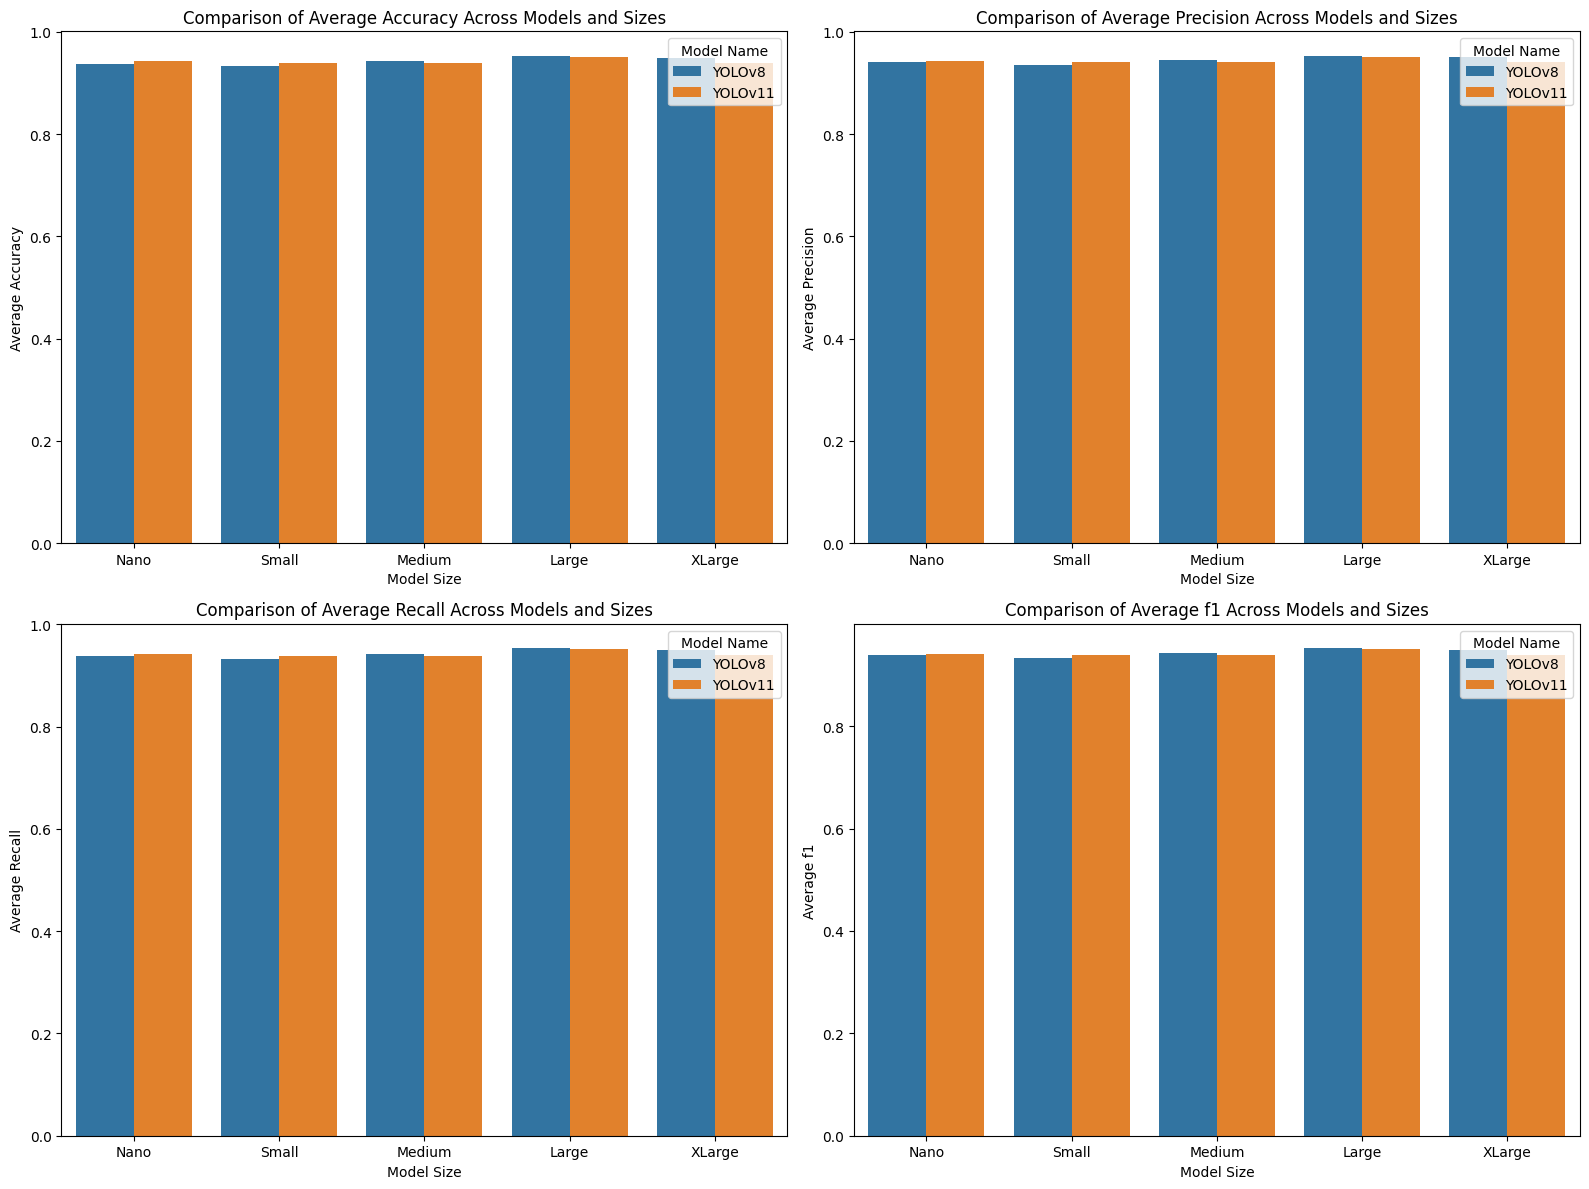

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the average results to a DataFrame
average_results_df = pd.DataFrame(average_results)

# Plot the key metrics (accuracy, precision, recall, F1) across different models and sizes
metrics = ["Average Accuracy", "Average Precision", "Average Recall", "Average f1"]

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=average_results_df, x="Model Size", y=metric, hue="Model Name")
    plt.title(f"Comparison of {metric} Across Models and Sizes")
    plt.ylabel(metric)
    plt.xlabel("Model Size")
    plt.legend(title="Model Name")

plt.tight_layout()
plt.show()


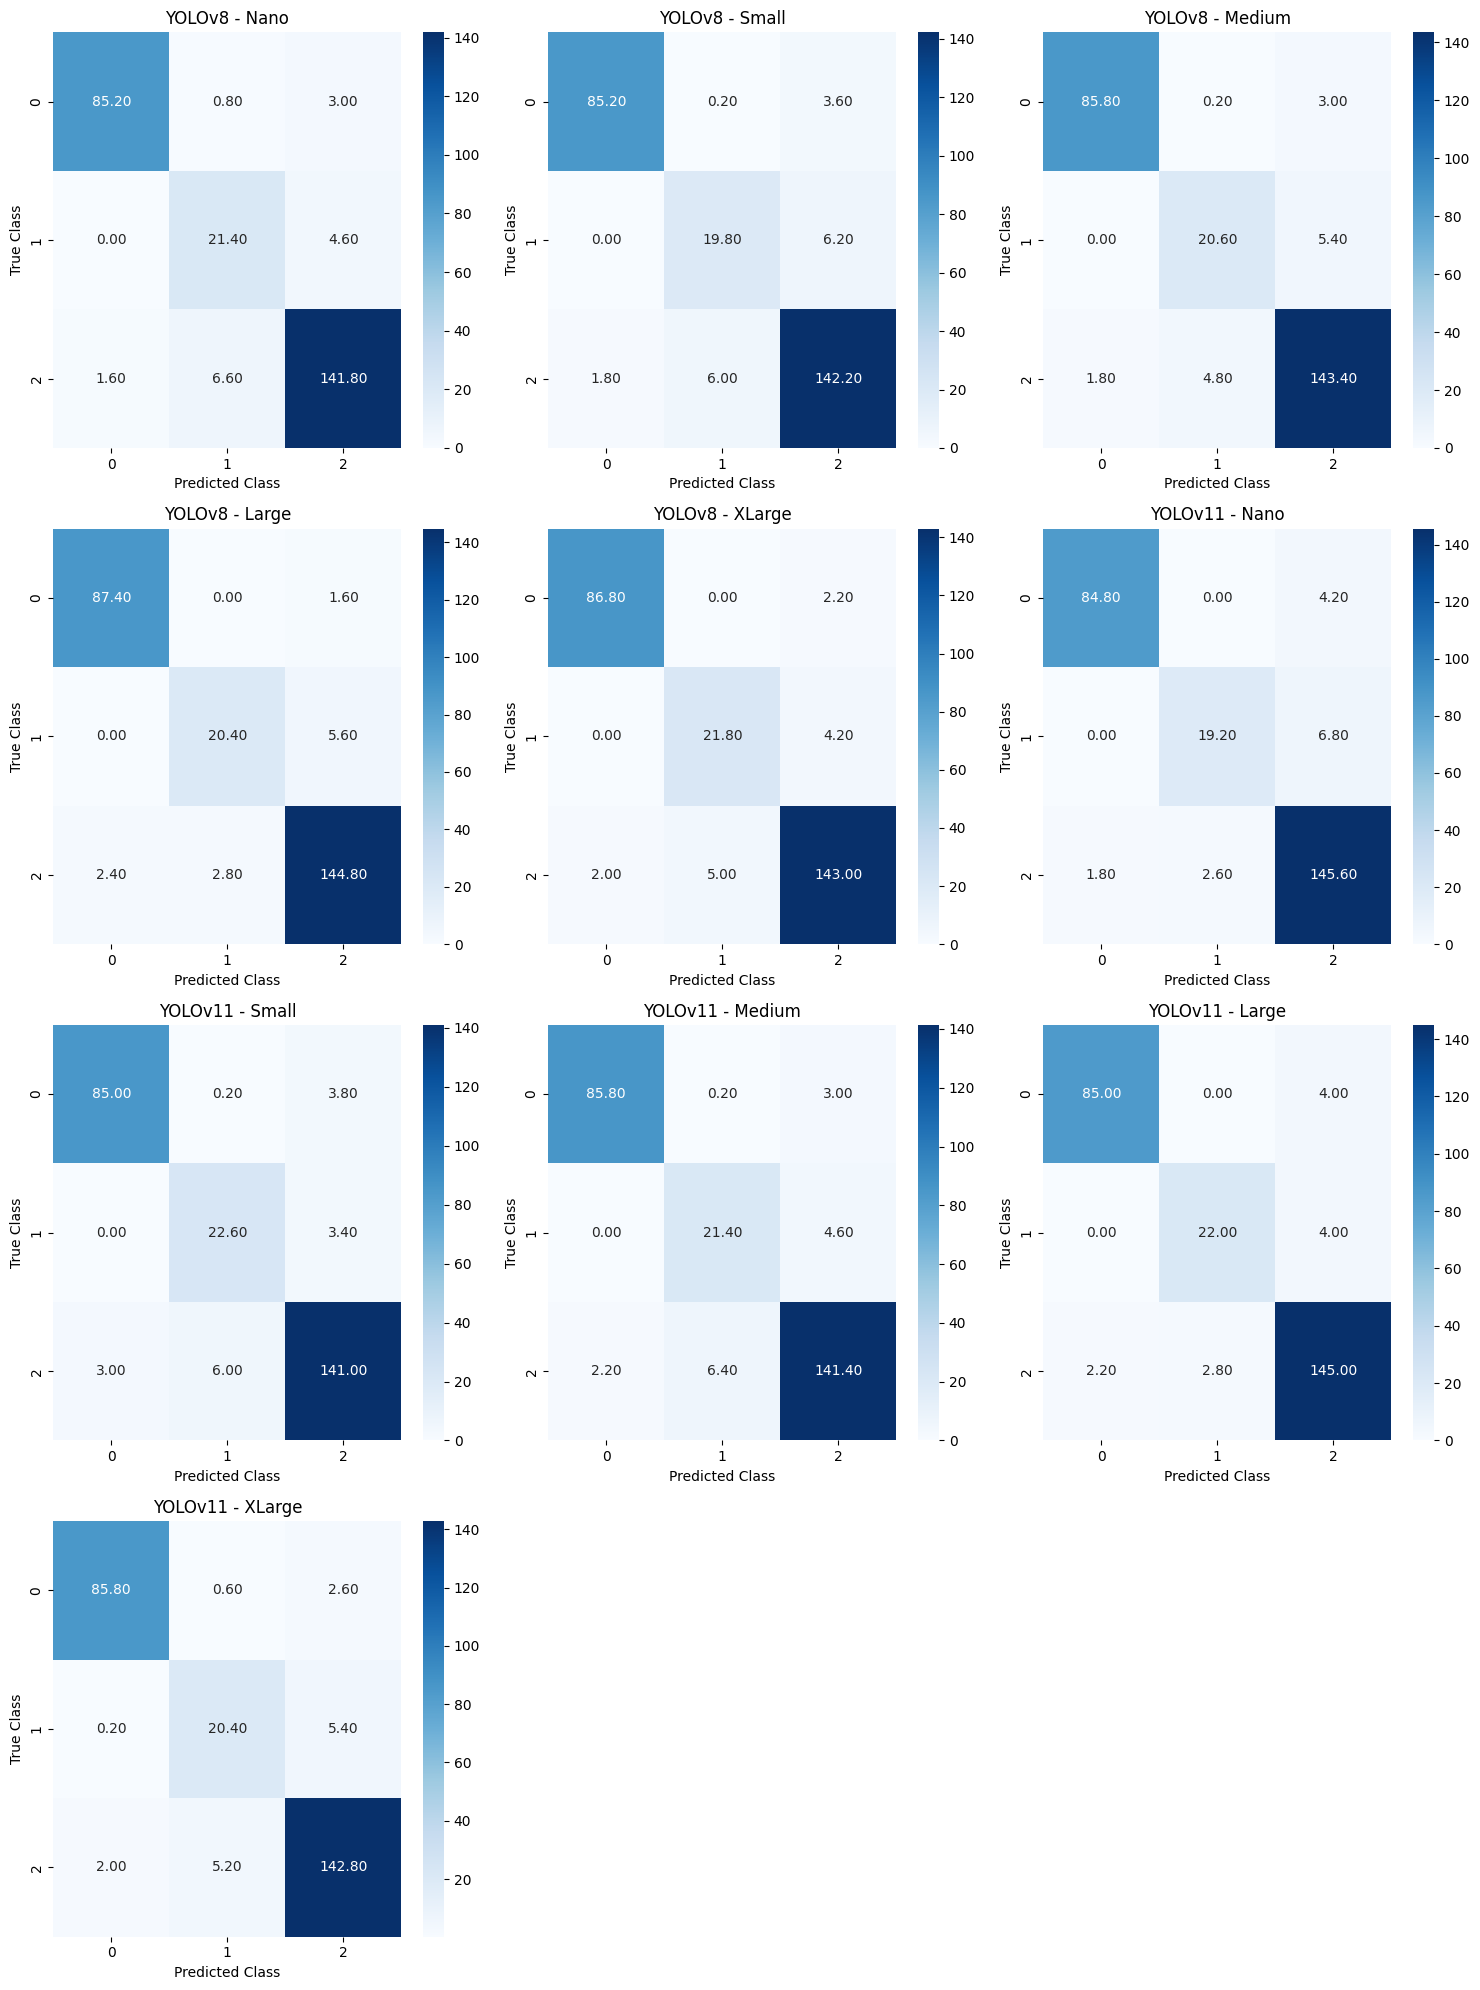

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows and columns for the grid
num_matrices = len(average_results_df)
ncols = 3  # Number of columns in the grid
nrows = (num_matrices // ncols) + (num_matrices % ncols > 0)  # Calculate rows needed

# Set up the figure for the grid of confusion matrices
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Flatten axes to easily iterate over them
axes = axes.flatten()

# Plot each confusion matrix in the grid
for index, (ax, row) in enumerate(zip(axes, average_results_df.iterrows())):
    row_data = row[1]
    sns.heatmap(row_data["Average Confusion Matrix"], annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=ax)
    ax.set_title(f"{row_data['Model Name']} - {row_data['Model Size']}")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("True Class")

# Remove any unused subplots
for i in range(num_matrices, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Experiment Settings
- 200 Images for each class for training
- The rest of the images goes to val and test sets
- Val and test sets splits are 50%-50% (26 - clear, 150 - cloudy and 89 - amber )

## Experiment results
- Good Results
- Around 93% for all metrics (accuracy, precision, recall and f1)
- In conf matrix class 0 = amber, 1 = clear and 2 = cloudy
- Best model to predict amber class is yolov8 Large.
